In [28]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

## 1. Load Images and Define Source
This cell loads the primary `indoor.jpg` (our target) and the `material.jpg` (our source texture). It converts them to RGB color space for processing and defines the source coordinates (`src_pts`) of the flat material, which will be mapped onto our target polygons.

In [29]:
# Load Images and Define Source Material Points

indoor_img = cv2.imread("indoor.jpeg")
material_img = cv2.imread("material.jpeg")

# Error check
if indoor_img is None:
    raise Exception("Could not read 'indoor.jpeg'. Make sure the file is in the correct path.")
if material_img is None:
    raise Exception("Could not read 'material.jpeg'. Make sure the file is in the correct path.")

# Convert images from BGR to RGB
indoor_img = cv2.cvtColor(indoor_img, cv2.COLOR_BGR2RGB)
material_img = cv2.cvtColor(material_img, cv2.COLOR_BGR2RGB)

# Create a copy of the indoor image. We will apply our changes to this copy.
result_img = indoor_img.copy()

# Get the dimensions of the material image
h_material, w_material, _ = material_img.shape

src_pts = np.array([
    [0, 0],
    [w_material - 1, 0],
    [w_material - 1, h_material - 1],
    [0, h_material - 1]
], dtype=np.float32)

print(f"Images loaded successfully. Indoor: {indoor_img.shape}, Material: {material_img.shape}")

Images loaded successfully. Indoor: (1440, 2560, 3), Material: (946, 1683, 3)


## 2. Define Target Coordinates
I manually defined the 10 coordinates for the target polygons in the `indoor.jpeg` image. These points map to the two faces of the kitchen island (front and top) and the back wall (backsplash) where the new material will be applied.

In [30]:
# Island Coordinates
island_front_top_left = [1069, 840]
island_front_top_right = [2135, 840]
island_front_bottom_left = [1069, 1179]
island_front_bottom_right = [2135, 1179]
island_top_back_left = [1103, 811]
island_top_back_right = [2002, 811]

# Wall Coordinates
wall_top_left = [609, 583]
wall_top_right = [1785, 583]
wall_bottom_right = [1785, 786]
wall_bottom_left = [609, 786]

print("All 10 target coordinates have been defined.")

All 10 target coordinates have been defined.


## 3. Diagnostic: Visualize Target Regions
Before proceeding to the transformation, I run this diagnostic cell. It draws my defined polygons (red for island front, green for island top, blue for the wall) onto the original image. This is a critical step to visually confirm that all 10 coordinates are accurate and correctly map to the target areas.

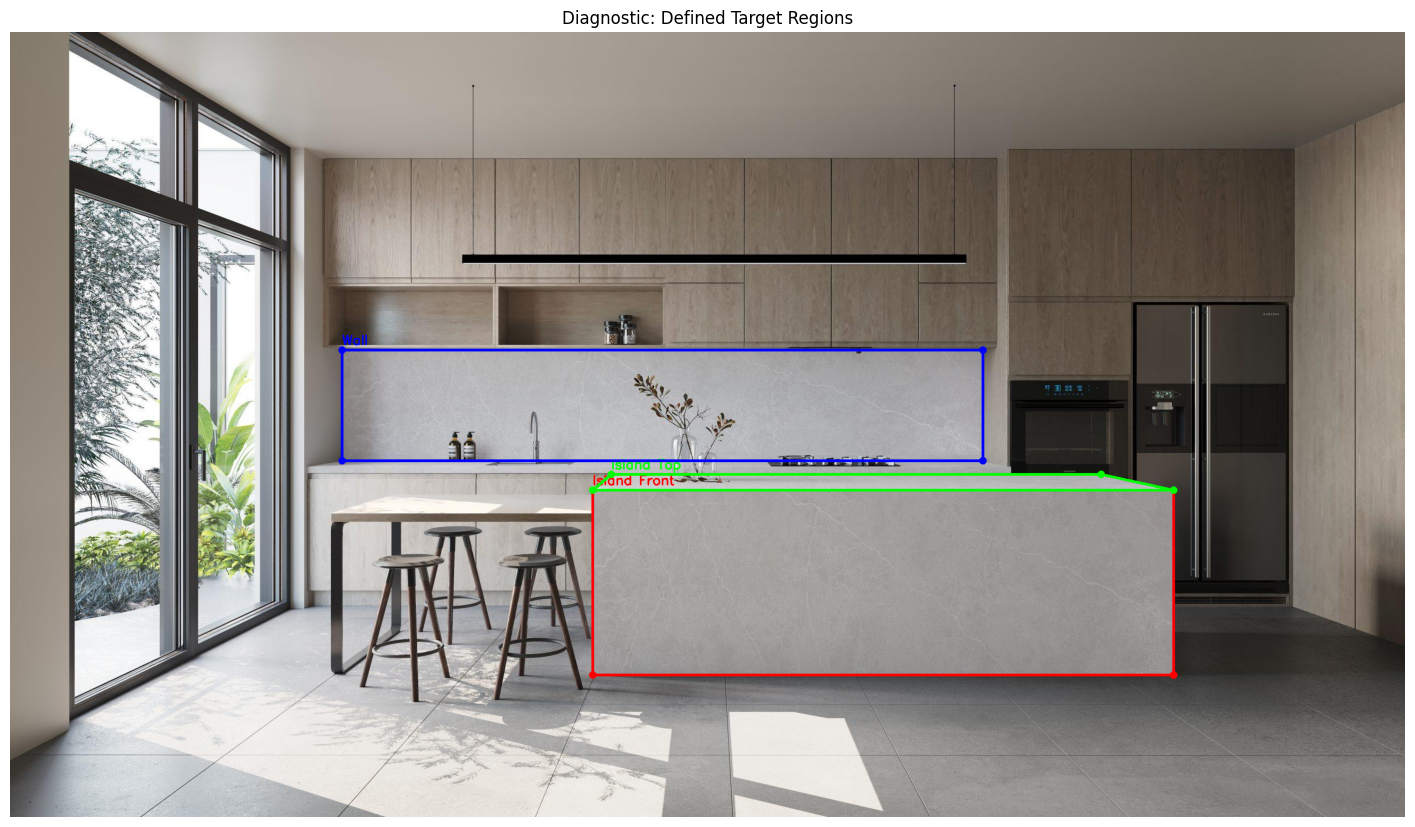

Diagnostic image displayed.


In [31]:
# Create a copy of the image to draw on
diagnostic_img = indoor_img.copy() 

# Define and draw the Island Front polygon (Red)
pts_island_front_draw = np.array([
    island_front_top_left,
    island_front_top_right,
    island_front_bottom_right,
    island_front_bottom_left
], dtype=np.int32)
cv2.polylines(diagnostic_img, [pts_island_front_draw], True, (255, 0, 0), 3) 
for pt in pts_island_front_draw:
    cv2.circle(diagnostic_img, tuple(pt), 7, (255, 0, 0), -1) 
cv2.putText(diagnostic_img, "Island Front", (island_front_top_left[0], island_front_top_left[1]-10), 
            cv2.FONT_HERSHEY_SIMPLEX, 0.8, (255, 0, 0), 2)

# Define and draw the Island Top polygon (Green)
pts_island_top_draw = np.array([
    island_top_back_left,
    island_top_back_right,
    island_front_top_right, # Shared point
    island_front_top_left   # Shared point
], dtype=np.int32)
cv2.polylines(diagnostic_img, [pts_island_top_draw], True, (0, 255, 0), 3) 
for pt in pts_island_top_draw:
    cv2.circle(diagnostic_img, tuple(pt), 7, (0, 255, 0), -1) 
cv2.putText(diagnostic_img, "Island Top", (island_top_back_left[0], island_top_back_left[1]-10), 
            cv2.FONT_HERSHEY_SIMPLEX, 0.8, (0, 255, 0), 2)

# Define and draw the Wall polygon (Blue)
pts_wall_draw = np.array([
    wall_top_left,
    wall_top_right,
    wall_bottom_right,
    wall_bottom_left
], dtype=np.int32)
cv2.polylines(diagnostic_img, [pts_wall_draw], True, (0, 0, 255), 3) 
for pt in pts_wall_draw:
    cv2.circle(diagnostic_img, tuple(pt), 7, (0, 0, 255), -1) 
cv2.putText(diagnostic_img, "Wall", (wall_top_left[0], wall_top_left[1]-10), 
            cv2.FONT_HERSHEY_SIMPLEX, 0.8, (0, 0, 255), 2)

# Display the final diagnostic image
plt.figure(figsize=(18, 12))
plt.imshow(diagnostic_img)
plt.title("Diagnostic: Defined Target Regions")
plt.axis('off')
plt.show()

print("Diagnostic image displayed.")

## 4. Method Part 1: Apply Texture to Island Front
This is the first processing step. I calculate the perspective transformation matrix (`M_island_front`) to map the flat source texture to the 4-point polygon of the island's front face. I then warp the texture and create a binary mask of the polygon. Finally, I use this mask to blend the new, warped texture onto the main result image.

In [32]:
# Define the 4 destination points for the front face
dst_pts_island_front = np.array([
    island_front_top_left,
    island_front_top_right,
    island_front_bottom_right,
    island_front_bottom_left
], dtype=np.float32)

# Calculate the perspective transform matrix
M_island_front = cv2.getPerspectiveTransform(src_pts, dst_pts_island_front)

# Warp the material image to fit the destination polygon
warped_material_front = cv2.warpPerspective(material_img, M_island_front, (indoor_img.shape[1], indoor_img.shape[0]))

# Create a binary mask for just the front face
mask_front = np.zeros(indoor_img.shape[:2], dtype=np.uint8)
cv2.fillPoly(mask_front, [np.int32(dst_pts_island_front)], (255))

# Apply the warped material to the result image using the mask
for c in range(3):
    result_img[:, :, c] = np.where(mask_front == 255,
                                   warped_material_front[:, :, c],
                                   result_img[:, :, c])

print("Island Front Face complete.")

Island Front Face complete.


## 5. Method Part 2: Apply Texture to Island Top
This step repeats the same process for the island's top surface. I use the two remaining 'back' coordinates combined with the two shared 'front' coordinates to define the top polygon. A separate transformation and mask are created and applied to the `result_img`, which now contains the textured front face.

In [33]:
# Define the 4 destination points for the top surface
dst_pts_island_top = np.array([
    island_top_back_left,
    island_top_back_right,
    island_front_top_right,
    island_front_top_left
], dtype=np.float32)

# Calculate the perspective transform matrix
M_island_top = cv2.getPerspectiveTransform(src_pts, dst_pts_island_top)

# Warp the material image
warped_material_top = cv2.warpPerspective(material_img, M_island_top, (indoor_img.shape[1], indoor_img.shape[0]))

# Create a binary mask for the top surface
mask_top = np.zeros(indoor_img.shape[:2], dtype=np.uint8)
cv2.fillPoly(mask_top, [np.int32(dst_pts_island_top)], (255))

# Apply the warped material to the result image
for c in range(3):
    result_img[:, :, c] = np.where(mask_top == 255, 
                                   warped_material_top[:, :, c], 
                                   result_img[:, :, c])

print("Island Top Surface complete.")

Island Top Surface complete.


## 6. Method Part 3: Apply Texture to Wall
This final step applies the texture to the back wall, which is the most complex part due to occlusion from foreground objects (tap, bottles) and shadows from the top cabinets.

My method is as follows:
1.  Warp the texture to the wall polygon, just like with the island.
2.  Create a second, "occlusion mask" by thresholding the original image's brightness. This identifies dark pixels (objects and shadows) that should not be overwritten.
3.  Subtract this occlusion mask from the main wall mask to create a final mask.
4.  Apply the texture only where this final mask allows.

After experimenting with different thresholds and blurring techniques, I found this brightness threshold method (THRESHOLD = 110) gives the best balance. It successfully preserves the foreground objects, although some minor shadow artifacts remain along the bottom edge. 

In [34]:
# Define the 4 destination points for the wall
dst_pts_wall = np.array([
    wall_top_left,
    wall_top_right,
    wall_bottom_right,
    wall_bottom_left
], dtype=np.float32)

# Calculate the perspective transform matrix and warp the material
M_wall = cv2.getPerspectiveTransform(src_pts, dst_pts_wall)
warped_material_wall = cv2.warpPerspective(material_img, M_wall, (indoor_img.shape[1], indoor_img.shape[0]))

# 3Create the base mask for the entire wall area
mask_wall_base = np.zeros(indoor_img.shape[:2], dtype=np.uint8)
cv2.fillPoly(mask_wall_base, [np.int32(dst_pts_wall)], (255))

# 4Get the bounding box of the wall area to process only that region
y_min = min(wall_top_left[1], wall_top_right[1])
y_max = max(wall_bottom_left[1], wall_bottom_right[1])
x_min = min(wall_top_left[0], wall_bottom_left[0])
x_max = max(wall_top_right[0], wall_bottom_right[0])

# Extract the original wall area from the source image
original_wall_area = indoor_img[y_min:y_max, x_min:x_max]

# Convert this small area to grayscale to check brightness
gray_wall_area = cv2.cvtColor(original_wall_area, cv2.COLOR_RGB2GRAY)

# Create the occlusion mask
OCCLUSION_THRESHOLD = 110 
_, occlusion_mask_area = cv2.threshold(gray_wall_area, OCCLUSION_THRESHOLD, 255, cv2.THRESH_BINARY_INV)

# Place this small occlusion mask back into a full-sized black image
occlusion_mask_full = np.zeros(indoor_img.shape[:2], dtype=np.uint8)
occlusion_mask_full[y_min:y_max, x_min:x_max] = occlusion_mask_area

# Calculate the final wall mask
final_wall_mask = cv2.bitwise_and(mask_wall_base, cv2.bitwise_not(occlusion_mask_full))

# Apply the material
for c in range(3):
    result_img[:, :, c] = np.where(final_wall_mask == 255, 
                                   warped_material_wall[:, :, c], 
                                   result_img[:, :, c])

print("Wall processing complete.")

Wall processing complete.


## 7. Show the result

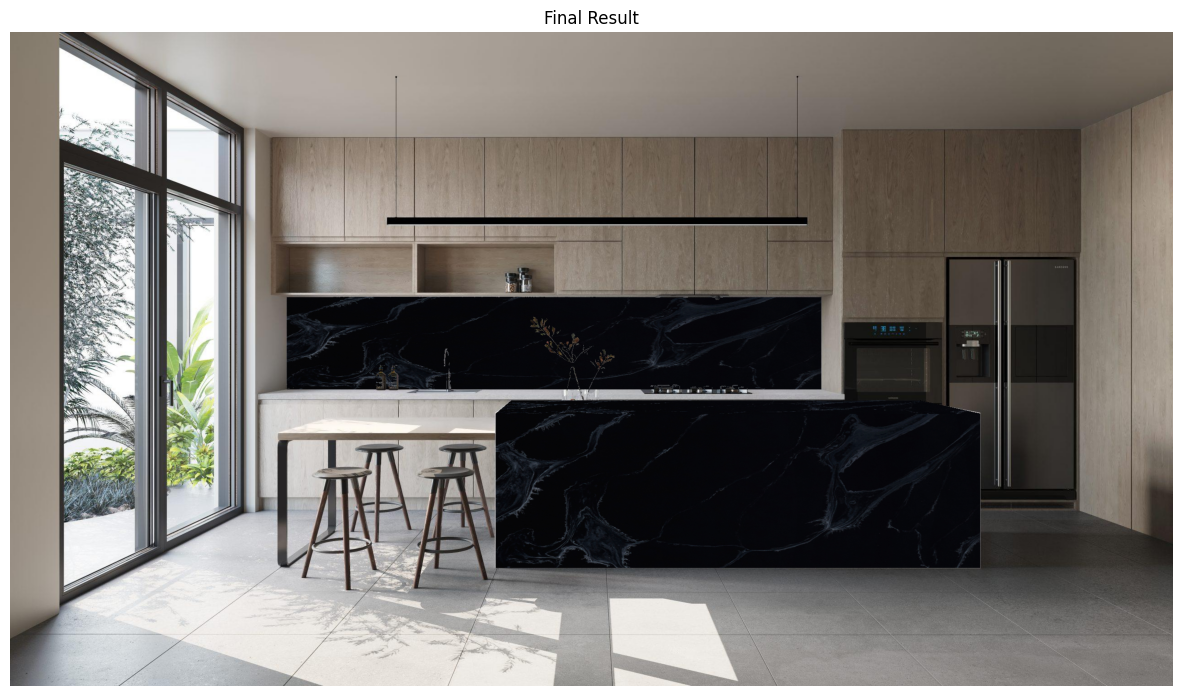

In [35]:
plt.figure(figsize=(15, 10))
plt.imshow(result_img)
plt.title("Final Result")
plt.axis('off')
plt.show()

## 8. Generate the result image

In [36]:
# Convert the image from RGB back to BGR
result_img_bgr = cv2.cvtColor(result_img, cv2.COLOR_RGB2BGR)

# Save the image
try:
    cv2.imwrite("result_image.jpg", result_img_bgr)
    print("Result saved successfully to 'result_image.jpg'")
except Exception as e:
    print(f"Error saving image: {e}")

Result saved successfully to 'result_image.jpg'
